In [4]:
!pip install wandb -qU

In [5]:
import copy
import wandb

import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

#using numpy
import numpy as np

#for data load or save
import pandas as pd

#visualize some datasets
import matplotlib.pyplot as plt

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [43]:
train = pd.read_csv('/kaggle/input/face-1/train (7).csv')
#test = pd.read_csv('/content/data/data_for_achive/test/image_names.csv')

In [44]:
print(train.shape)
#print(test.shape)

(8000, 2)


In [45]:
train

,name,label
0,train_5235410406999412.png,0
1,train_9050265579485831.png,1
2,train_4778558969322365.png,1
3,train_97406946215391.png,0
4,train_3428454526298198.png,0
...,...,...
7995,train_1931809411957886.png,1
7996,train_7150402262536954.png,1
7997,train_4220356804535418.png,0
7998,train_5120475238211757.png,0


In [46]:
np.unique(train['label'],return_counts=True)

(array([0, 1]), array([3991, 4009]))

In [47]:
import os
train_dir = '/kaggle/input/data-faces/data256/train'
test_dir = '/kaggle/input/data-faces/data256/test'

In [48]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.png'))
test_list = glob.glob(os.path.join(test_dir, '*.png'))


In [49]:
#test_list = [f"{test_dir}/test_{str(i).rjust(4, '0')}.png" for i in range(5000)]

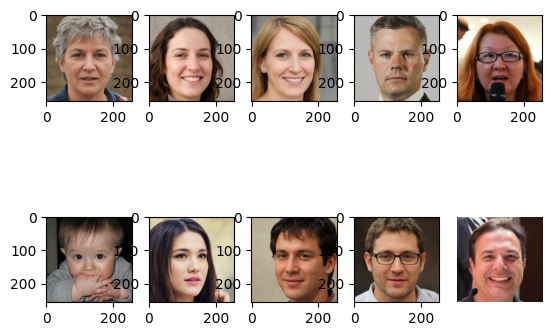

In [50]:
from PIL import Image
random_idx = np.random.randint(1,8000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [51]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [52]:

#data Augumentation
transforms =  transforms.Compose([
        transforms.Resize((100, 100))
        transforms.RandomHorizontalFlip(0.2)
        transforms.RandomRotation(degrees=30)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


SyntaxError: invalid syntax. Perhaps you forgot a comma? (144620333.py, line 3)

https://datagy.io/pytorch-transforms/

In [53]:
#train['count'] = train['count'] -1
#train

In [54]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform


    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img)
        label = int(train[train['name'] == img_path.split('/')[-1]]['label'])
        return img_transformed,label

In [55]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [104]:
train_data = dataset(train_list, transform=train_transform)
test_data = dataset(test_list, transform=valid_transform)
val_data = dataset(val_list, transform=valid_transform)

In [57]:
batch_size = 64

In [105]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [59]:
print(len(train_data), len(train_loader))

6400 100


In [79]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64*26*26,100)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100,5)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out



In [80]:
lr = 0.001 # learning_rate
epochs = 100 # How much to train a model

In [81]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [82]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=43264, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
 

In [83]:
#! pip install torchsummary 

In [84]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
       BatchNorm2d-2         [-1, 16, 222, 222]              32
              ReLU-3         [-1, 16, 222, 222]               0
         MaxPool2d-4         [-1, 16, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           4,640
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
         MaxPool2d-8           [-1, 32, 54, 54]               0
            Conv2d-9           [-1, 64, 52, 52]          18,496
      BatchNorm2d-10           [-1, 64, 52, 52]             128
             ReLU-11           [-1, 64, 52, 52]               0
        MaxPool2d-12           [-1, 64, 26, 26]               0
           Linear-13                  [-1, 100]       4,326,500
             ReLU-14                  [

In [86]:
lr = 0.01
optimizer = optim.AdamW(params = model.parameters(),lr=lr, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

wandb: Currently logged in as: daniil-berezin162003 (daniil_berezin). Use `wandb login --relogin` to force relogin


/tmp/ipykernel_34/562980237.py:17: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  label = int(train[train['name'] == img_path.split('/')[-1]]['label'])


Epoch [1/40], train Loss: 7.1788, train accuracy: 0.7889,  val Loss: 0.2647, val accuracy: 0.8875
best model saved!
Epoch [2/40], train Loss: 0.2519, train accuracy: 0.8967,  val Loss: 0.1963, val accuracy: 0.9219
best model saved!
Epoch [3/40], train Loss: 0.2135, train accuracy: 0.9136,  val Loss: 0.1855, val accuracy: 0.9206
best model saved!
Epoch [4/40], train Loss: 0.1978, train accuracy: 0.9202,  val Loss: 0.1912, val accuracy: 0.9144
Epoch [5/40], train Loss: 0.1883, train accuracy: 0.9250,  val Loss: 0.1601, val accuracy: 0.9344
best model saved!
Epoch [6/40], train Loss: 0.1862, train accuracy: 0.9258,  val Loss: 0.1816, val accuracy: 0.9231
Epoch [7/40], train Loss: 0.1571, train accuracy: 0.9397,  val Loss: 0.1385, val accuracy: 0.9500
best model saved!
Epoch [8/40], train Loss: 0.1555, train accuracy: 0.9369,  val Loss: 0.1513, val accuracy: 0.9394
Epoch [9/40], train Loss: 0.1402, train accuracy: 0.9466,  val Loss: 0.1440, val accuracy: 0.9438
Epoch [10/40], train Loss: 0

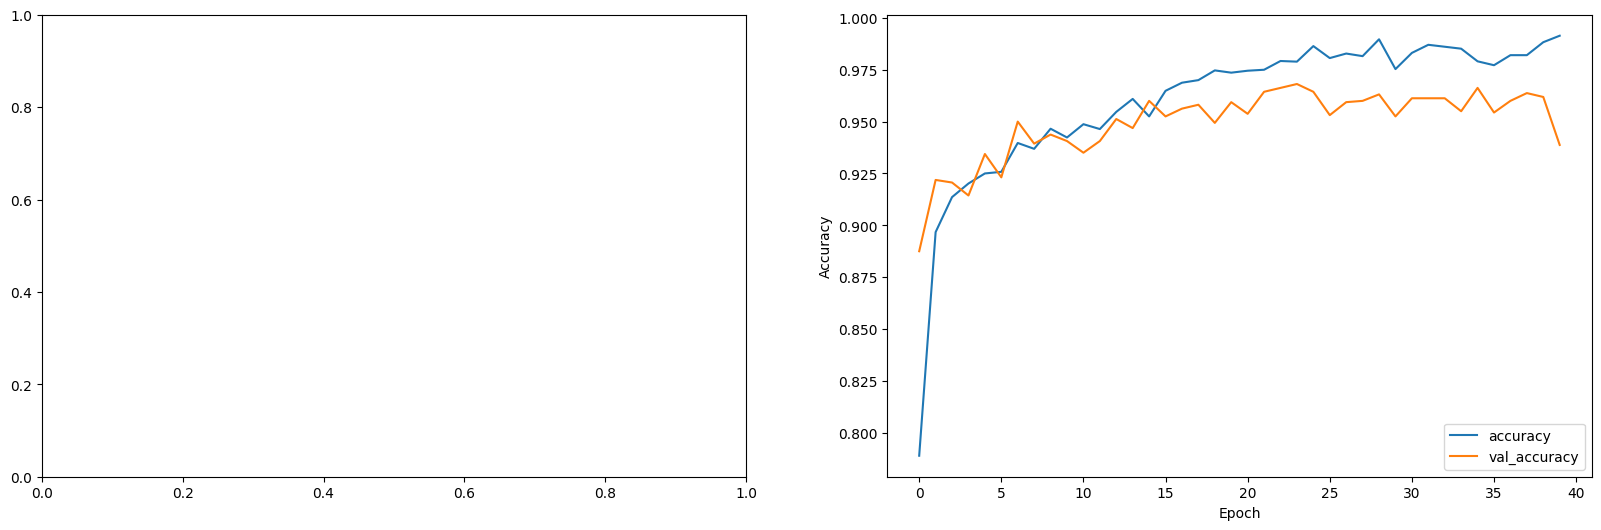

In [87]:
epochs = 40

accuracy_history = []
val_accuracy_history = []
loss_history = []
val_loss_history = []

best_val_loss = float('inf')
best_model = None

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6))

wandb.init(
    project="pytorch-intro",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": lr
        })

# Copy your config
config = wandb.config


for epoch in range(config.epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    accuracy_history.append(epoch_accuracy.detach().cpu().numpy())
    loss_history.append(epoch_loss.detach().cpu().numpy())

    metrics = {"train/train_loss": epoch_loss,
                "train/accuracy": epoch_accuracy}


    with torch.no_grad():

        epoch_val_accuracy=0
        epoch_val_loss =0

        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output,label)


            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
        print(f'Epoch [{epoch+1}/{epochs}], train Loss: {epoch_loss:.4f}, train accuracy: {epoch_accuracy:.4f},  val Loss: {epoch_val_loss:.4f}, val accuracy: {epoch_val_accuracy:.4f}')
        val_accuracy_history.append(epoch_val_accuracy.detach().cpu().numpy())
        val_loss_history.append(epoch_val_loss.detach().cpu().numpy())

        val_metrics = {"val/val_loss": epoch_val_loss,
                       "val/val_accuracy": epoch_val_accuracy}
        wandb.log({**metrics, **val_metrics})

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), 'best_model.pt')
            print('best model saved!')


plt.plot(accuracy_history, label='accuracy')
plt.plot(val_accuracy_history, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


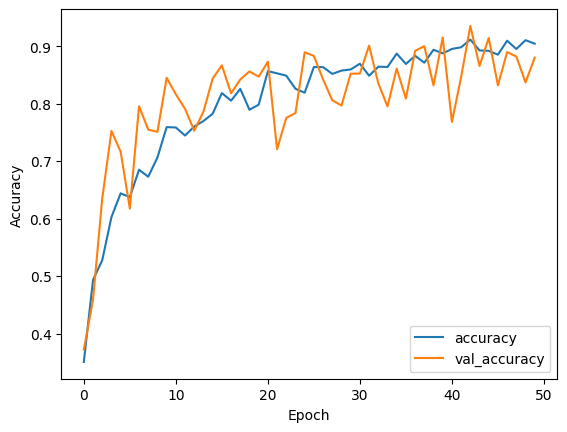

In [ ]:
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.eval()
ans = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = np.argmax(F.softmax(preds, dim=1).tolist(), axis = 1)
        for i in preds_list:
          ans.append(i+1)

In [ ]:
submission = pd.read_csv('/content/data/data_for_achive/test/sample_submission.csv')
submission['count'] =  ans
submission.to_csv("submission_93.csv", index=False)

In [ ]:
results = pd.Series(ans, name="Label")

submission.to_csv("submission.csv", index=False)

In [ ]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv

# Pre-train model

In [ ]:
import pickle
import numpy as np
from skimage import io
import pandas as pd

from tqdm import tqdm,tqdm_notebook
from PIL import Image
from pathlib import Path
import math

from torchvision import transforms
import torch
import torchvision
from torch.optim import lr_scheduler


In [ ]:
model = torchvision.models.resnet18(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


In [ ]:
n_classes = 5
model.fc = nn.Linear(512, n_classes)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
blocks_to_freeze = 5
for i, layer in enumerate(model.children()):
  if i < blocks_to_freeze:
    for param in layer.parameters():
      param.requires_grad = False

In [ ]:
criterion = nn.L1Loss()
optimmizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay=0.1)
scheduler = lr_scheduler.StepLR(optimmizer, step_size = 3, gamma = 0.5)

In [ ]:
lr = 0.01
optimizer = optim.AdamW(params = model.parameters(),lr=lr, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

Epoch [1/40], Train Loss: 0.4698, train accuracy: 0.8123

Epoch [1/40], Val Loss: 0.4413, val accuracy: 0.8039

best model saved!

Epoch [2/40], Train Loss: 0.4196, train accuracy: 0.8342

Epoch [2/40], Val Loss: 0.4045, val accuracy: 0.8301

best model saved!

Epoch [3/40], Train Loss: 0.3457, train accuracy: 0.8672

Epoch [3/40], Val Loss: 0.3606, val accuracy: 0.8592

best model saved!

Epoch [4/40], Train Loss: 0.3047, train accuracy: 0.8848

Epoch [4/40], Val Loss: 0.2335, val accuracy: 0.9118

best model saved!

Epoch [5/40], Train Loss: 0.2851, train accuracy: 0.8922

Epoch [5/40], Val Loss: 0.2373, val accuracy: 0.9216

Epoch [6/40], Train Loss: 0.2797, train accuracy: 0.8950

Epoch [6/40], Val Loss: 0.3574, val accuracy: 0.8741

Epoch [7/40], Train Loss: 0.2353, train accuracy: 0.9145

Epoch [7/40], Val Loss: 0.3135, val accuracy: 0.8825

Epoch [8/40], Train Loss: 0.2945, train accuracy: 0.8893

Epoch [8/40], Val Loss: 0.3220, val accuracy: 0.8685

Epoch [9/40], Train Loss: 0.

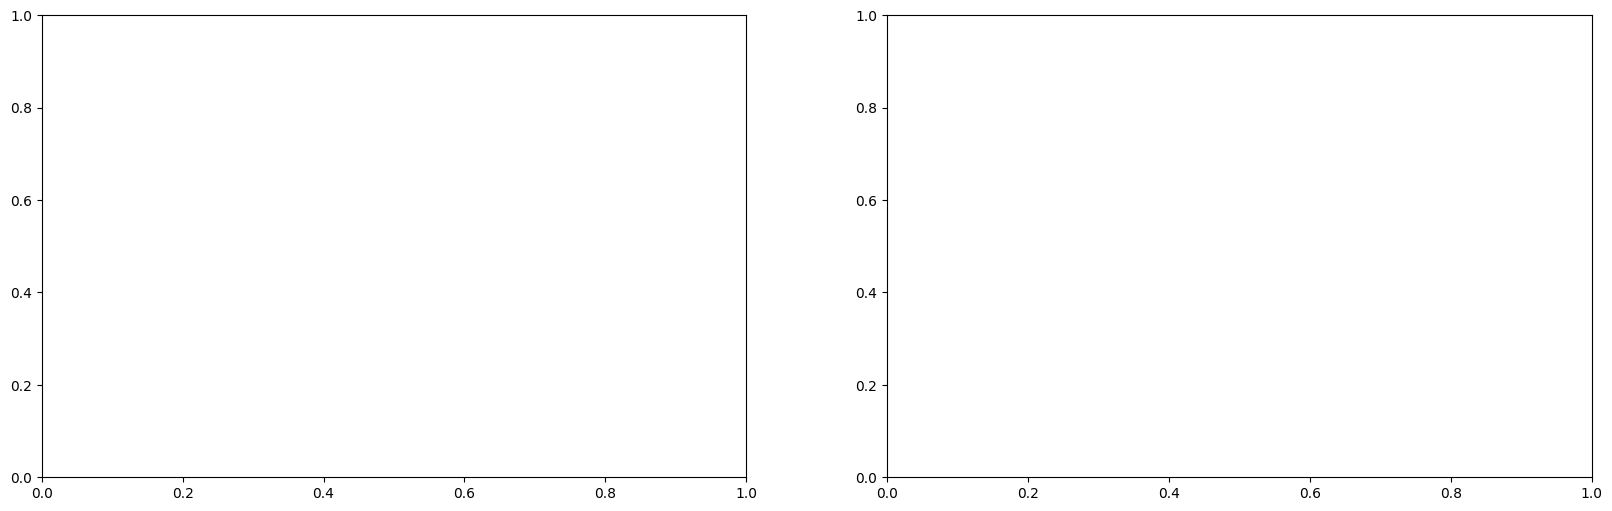

In [ ]:
epochs = 40

accuracy_history = []
val_accuracy_history = []
loss_history = []
val_loss_history = []

best_val_loss = float('inf')
best_model = None

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

wandb.init(
    project="pytorch-intro",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": lr
        })

# Copy your config
config = wandb.config


for epoch in range(config.epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
    accuracy_history.append(epoch_accuracy.detach().cpu().numpy())
    loss_history.append(epoch_loss.detach().cpu().numpy())

    metrics = {"train/train_loss": epoch_loss,
                "train/accuracy": epoch_accuracy}


    with torch.no_grad():

        epoch_val_accuracy=0
        epoch_val_loss =0

        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output,label)


            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
        print(f'Epoch [{epoch+1}/{epochs}], train Loss: {epoch_loss:.4f}, train accuracy: {epoch_accuracy:.4f},  val Loss: {epoch_val_loss:.4f}, val accuracy: {epoch_val_accuracy:.4f}')
        val_accuracy_history.append(epoch_val_accuracy.detach().cpu().numpy())
        val_loss_history.append(epoch_val_loss.detach().cpu().numpy())

        val_metrics = {"val/val_loss": epoch_val_loss,
                       "val/val_accuracy": epoch_val_accuracy}
        wandb.log({**metrics, **val_metrics})

        if epoch_val_loss < best_val_loss:

          best_val_loss = epoch_val_loss
          best_model = copy.deepcopy(model)
          torch.save(best_model.state_dict(), 'best_model.pt')
          print('best model saved!')


plt.plot(accuracy_history, label='accuracy')
plt.plot(val_accuracy_history, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
torch.save(best_model.state_dict(), 'best_model.pt')

## Predict

In [88]:
test_dir = '/kaggle/input/data-faces/data256/test'

test_paths = glob.glob("/kaggle/input/data-faces/data256/test/*.png")
test_names = [t_path.split('/')[-1] for t_path in test_paths]

In [103]:
test_df = pd.DataFrame(test_names, columns=['name'])
test_df

,name
0,test_9644431561422832.png
1,test_2228438497082278.png
2,test_3467782738128628.png
3,test_3714460898255147.png
4,test_4854118735060452.png
...,...
11995,test_5481532896165539.png
11996,test_2209754200686773.png
11997,test_1089716907098553.png
11998,test_1169715892724708.png


In [107]:
class dataset_test(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform


    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img)
        return img_transformed

In [108]:
test_data = dataset_test(test_list, transform=valid_transform)

In [109]:
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)

In [100]:
from tqdm.notebook import tqdm

In [110]:
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)
    
    predicts.append(pred.softmax(dim=1)[:, 1].cpu().detach().numpy()) # argmax(dim=1)

  0%|          | 0/188 [00:00<?, ?it/s]

In [111]:
predicts = np.concatenate(predicts)

In [112]:
submit_df = pd.DataFrame([[name, pred] for name, pred in zip(test_names, predicts)], columns=['name', 'pred'])

In [113]:
submit_df = submit_df.sort_values(['name'])
submit_df.sample(5)

,name,pred
5778,test_6656130170303375.png,0.015644
3211,test_28123038532173.png,0.023265
5965,test_6064746188793475.png,0.027829
11970,test_9136781243038689.png,1.000000
11968,test_8417318910587336.png,1.000000


In [118]:
submit_df[:6000].to_csv("submit_11.csv", index=False)

In [117]:
len(submit_df[:6000])

6000